In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12, 4)

In [3]:
inputdata1 = "../output_qt/combined_qt_data/"
outputdata1 = "../output_qt/regressiondata_qt/"

In [4]:
def get_data():
    get_data = pd.read_csv(inputdata1 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)
    first_date = get_data.index[0]

    get_data.index = pd.date_range(first_date, get_data.index[-1], freq='QS').date
    return get_data

In [5]:
df = get_data()

In [6]:
df.columns

Index(['gdp_total', 'imports_goods_services', 'household_cons',
       'gov_consumption', 'investments', 'gpd_invest_business_households',
       'gov_invest', 'change_supply', 'exports_goods_services',
       'gdp_total_deseasonalized', 'imports_goods_services_deseasonalized',
       'household_cons_deseasonalized', 'gov_consumption_deseasonalized',
       'investments_deseasonalized',
       'gpd_invest_business_households_deseasonalized',
       'gov_invest_deseasonalized', 'change_supply_deseasonalized',
       'exports_goods_services_deseasonalized',
       'BeloningSeizoengecorrigeerd_2', 'Loonkosten_7',
       'BeloningVanWerknemers_8', 'Netherlands_GDP', 'Germany_GDP',
       'France_GDP', 'Italy_GDP', 'Spain_GDP', 'Belgium_GDP'],
      dtype='object')

<Axes: >

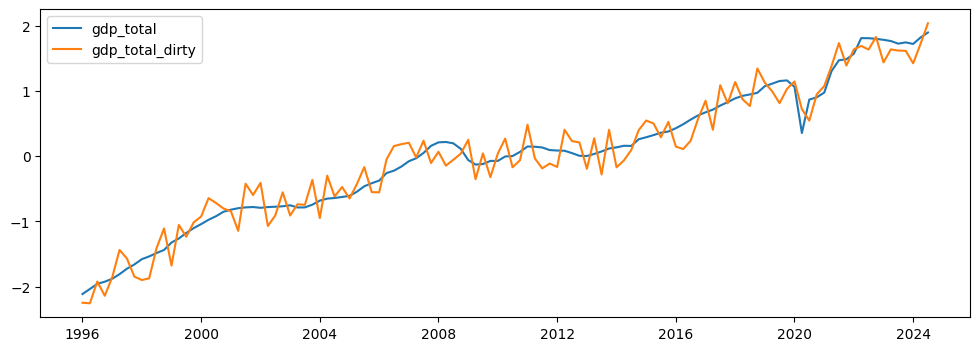

In [7]:
from sklearn.preprocessing import StandardScaler
import random


# subset of the data
df1 = df[[
        # 'gdp_total',
        # 'imports_goods_services',
        # 'household_cons',
        # 'gov_consumption', 
        # 'investments', 
        # 'gpd_invest_business_households',
        # 'gov_invest', 
        # 'change_supply', 
        # 'exports_goods_services',
        'gdp_total_deseasonalized', 
        'imports_goods_services_deseasonalized',
        'household_cons_deseasonalized', 
        'gov_consumption_deseasonalized',
        'investments_deseasonalized',
        'gpd_invest_business_households_deseasonalized',
        'gov_invest_deseasonalized', 
        'change_supply_deseasonalized',
        'exports_goods_services_deseasonalized',
        'BeloningSeizoengecorrigeerd_2', 
        'Loonkosten_7',
        'BeloningVanWerknemers_8', 
        'Germany_GDP',
        'France_GDP', 
        'Italy_GDP', 
        'Spain_GDP', 
        'Belgium_GDP' 
        ]]


#############################
# change if seasonally adjusted
#############################
if(any([col for col in df.columns if 'gdp_total_deseasonalized' in col])):
    df1.rename(columns={'gdp_total_deseasonalized': 'gdp_total'}, inplace=True)


# create a sure-fire predictor
df1['gdp_total_dirty'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# scale data to make comparable
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)

scaled_features_df[['gdp_total','gdp_total_dirty']].plot()


In [8]:
scaled_features_df.head()

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.700671,-1.719203,NaN,-1.826380,-1.956485,NaN,-2.268526,-1.836933,NaN
1995-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.662912,-1.370268,NaN,-1.751343,-1.904910,NaN,-1.965803,-1.653072,NaN
1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.637459,-1.681575,NaN,-1.621475,-2.148884,NaN,-2.141781,-1.831052,NaN
1995-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.602870,-1.572195,NaN,-1.494491,-1.787402,NaN,-1.775144,-1.536782,NaN
1996-01-01,-2.113368,-1.691106,-2.705271,-1.858223,-2.02642,-1.786021,-2.801249,0.355972,-1.64059,-1.618999,-1.646859,0.21731,-1.848506,-1.874681,-2.499954,-2.154475,-1.785378,-2.247107


### Deseasonalize if needed (Kruskal-Wallis test)

[ 0  1  2  7  8 16]
['imports_goods_services_deseasonalized', 'household_cons_deseasonalized', 'gov_consumption_deseasonalized', 'exports_goods_services_deseasonalized', 'BeloningSeizoengecorrigeerd_2', 'gdp_total_dirty']


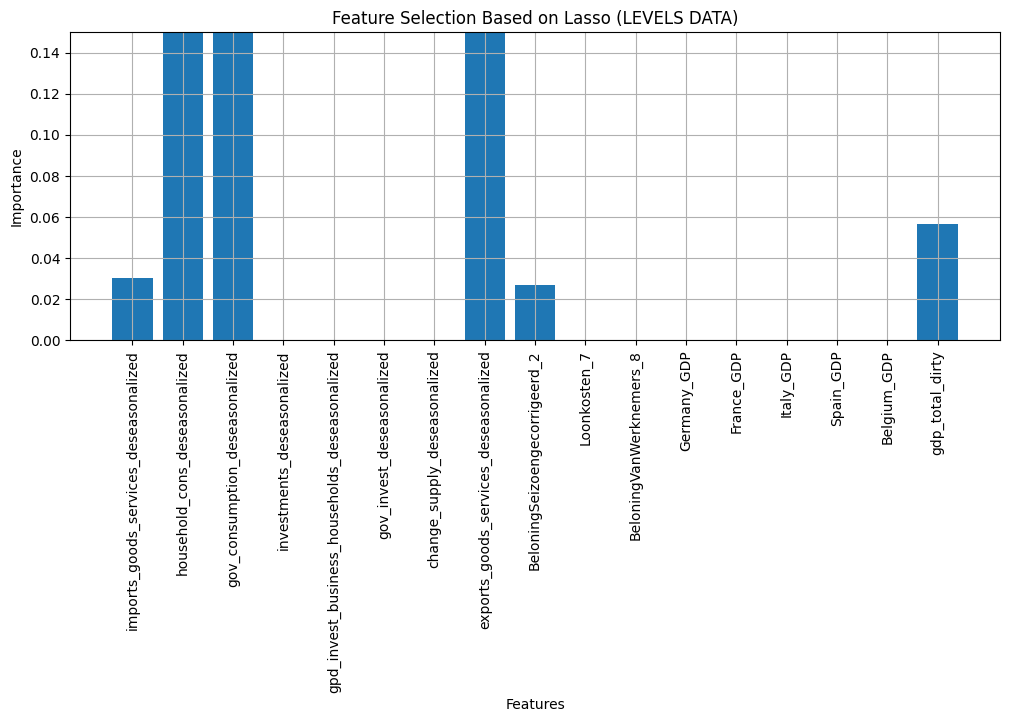

['imports_goods_services_deseasonalized',
 'household_cons_deseasonalized',
 'gov_consumption_deseasonalized',
 'exports_goods_services_deseasonalized',
 'BeloningSeizoengecorrigeerd_2',
 'gdp_total_dirty']

In [9]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables


lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

[ 1 10 13]
['household_cons_deseasonalized', 'BeloningVanWerknemers_8', 'Italy_GDP']


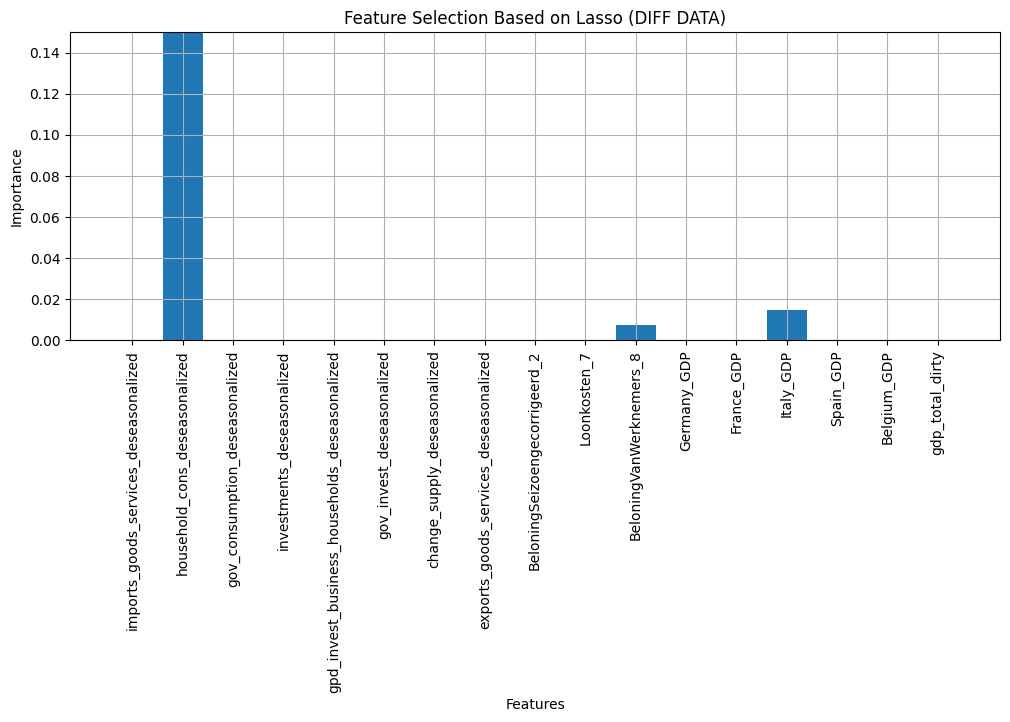

['household_cons_deseasonalized', 'BeloningVanWerknemers_8', 'Italy_GDP']

In [10]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.01, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [11]:
scaled_features_df.head()

,gdp_total,imports_goods_services_deseasonalized,household_cons_deseasonalized,gov_consumption_deseasonalized,investments_deseasonalized,gpd_invest_business_households_deseasonalized,gov_invest_deseasonalized,change_supply_deseasonalized,exports_goods_services_deseasonalized,BeloningSeizoengecorrigeerd_2,Loonkosten_7,BeloningVanWerknemers_8,Germany_GDP,France_GDP,Italy_GDP,Spain_GDP,Belgium_GDP,gdp_total_dirty
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.700671,-1.719203,NaN,-1.826380,-1.956485,NaN,-2.268526,-1.836933,NaN
1995-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.662912,-1.370268,NaN,-1.751343,-1.904910,NaN,-1.965803,-1.653072,NaN
1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.637459,-1.681575,NaN,-1.621475,-2.148884,NaN,-2.141781,-1.831052,NaN
1995-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.602870,-1.572195,NaN,-1.494491,-1.787402,NaN,-1.775144,-1.536782,NaN
1996-01-01,-2.113368,-1.691106,-2.705271,-1.858223,-2.02642,-1.786021,-2.801249,0.355972,-1.64059,-1.618999,-1.646859,0.21731,-1.848506,-1.874681,-2.499954,-2.154475,-1.785378,-2.247107


In [12]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty'] + selectThese 
df_lag = df[selectThese]

[ 0  1  2  4  7  8  9 10 11 14 18]
['gdp_total_dirty', 'gdp_total_lag_1', 'imports_goods_services_deseasonalized_lag_1', 'gov_consumption_deseasonalized_lag_1', 'gov_invest_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'exports_goods_services_deseasonalized_lag_1', 'BeloningSeizoengecorrigeerd_2_lag_1', 'Loonkosten_7_lag_1', 'France_GDP_lag_1', 'gdp_total_dirty_lag_1']


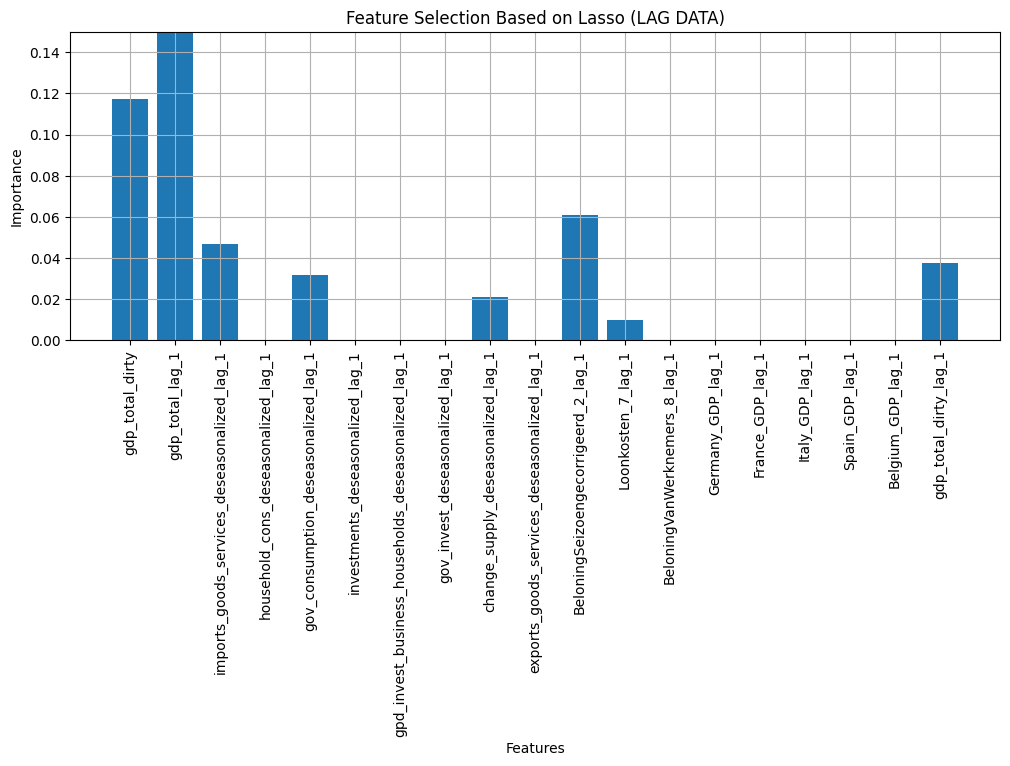

['gdp_total_dirty',
 'gdp_total_lag_1',
 'imports_goods_services_deseasonalized_lag_1',
 'gov_consumption_deseasonalized_lag_1',
 'gov_invest_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'exports_goods_services_deseasonalized_lag_1',
 'BeloningSeizoengecorrigeerd_2_lag_1',
 'Loonkosten_7_lag_1',
 'France_GDP_lag_1',
 'gdp_total_dirty_lag_1']

In [13]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  6  8 12 13 15 16 18]
['gdp_total_dirty', 'gpd_invest_business_households_deseasonalized_lag_1', 'change_supply_deseasonalized_lag_1', 'BeloningVanWerknemers_8_lag_1', 'Germany_GDP_lag_1', 'Italy_GDP_lag_1', 'Spain_GDP_lag_1', 'gdp_total_dirty_lag_1']


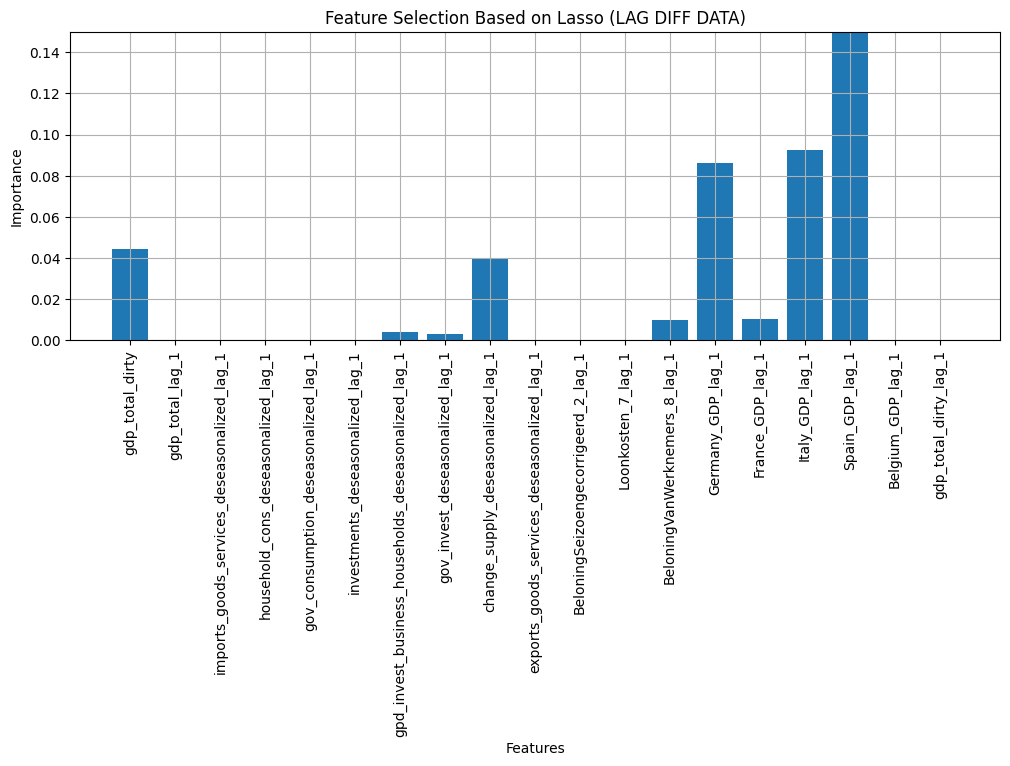

['gdp_total_dirty',
 'gpd_invest_business_households_deseasonalized_lag_1',
 'change_supply_deseasonalized_lag_1',
 'BeloningVanWerknemers_8_lag_1',
 'Germany_GDP_lag_1',
 'Italy_GDP_lag_1',
 'Spain_GDP_lag_1',
 'gdp_total_dirty_lag_1']

In [14]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 

### Make sure data is stationary

<Axes: >

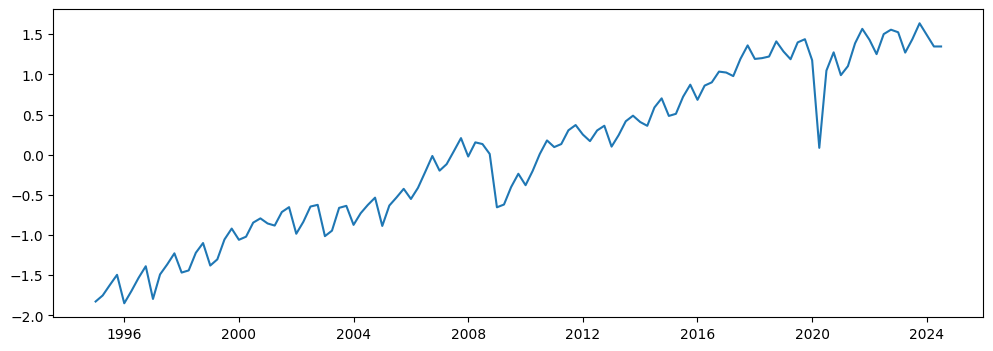

In [15]:
scaled_features_df['Germany_GDP'].plot()

In [16]:
timeseries = scaled_features_df['gov_consumption_deseasonalized']

In [17]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [18]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [19]:
def stationdarydf(mydata, save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
        else:
            stationary_features.append('NotStationary')
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df

#stationdarydf(scaled_features_df)

### If not stationary, difference, then test for stationarity again

replace in original data frame

In [20]:

def differenceData(originalData, mydiff=1):
    
    ## which features are not stationary
    # function from above
    stat1 = stationdarydf(originalData)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        stationarydf_diff.rename(columns={col: col + "_diff"}, inplace=True)
    

    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff

scaled_features_df_diff = differenceData(scaled_features_df, mydiff=1)

In [21]:
stationdarydf(scaled_features_df_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,114
1,imports_goods_services_deseasonalized_diff,Stationary,114
2,household_cons_deseasonalized_diff,Stationary,114
3,gov_consumption_deseasonalized_diff,Stationary,114
4,investments_deseasonalized_diff,Stationary,114
5,gpd_invest_business_households_deseasonalized_...,Stationary,114
6,gov_invest_deseasonalized_diff,Stationary,114
7,change_supply_deseasonalized_diff,Stationary,114
8,exports_goods_services_deseasonalized_diff,Stationary,114
9,BeloningSeizoengecorrigeerd_2_diff,NotStationary,118


<Axes: >

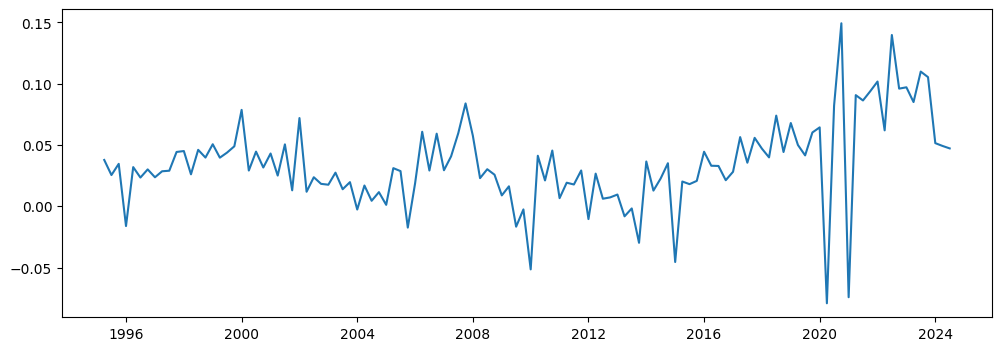

In [22]:
scaled_features_df_diff['BeloningSeizoengecorrigeerd_2_diff'].plot()

[ 1 10 13]
['household_cons_deseasonalized_diff', 'BeloningVanWerknemers_8_diff', 'Italy_GDP_diff']


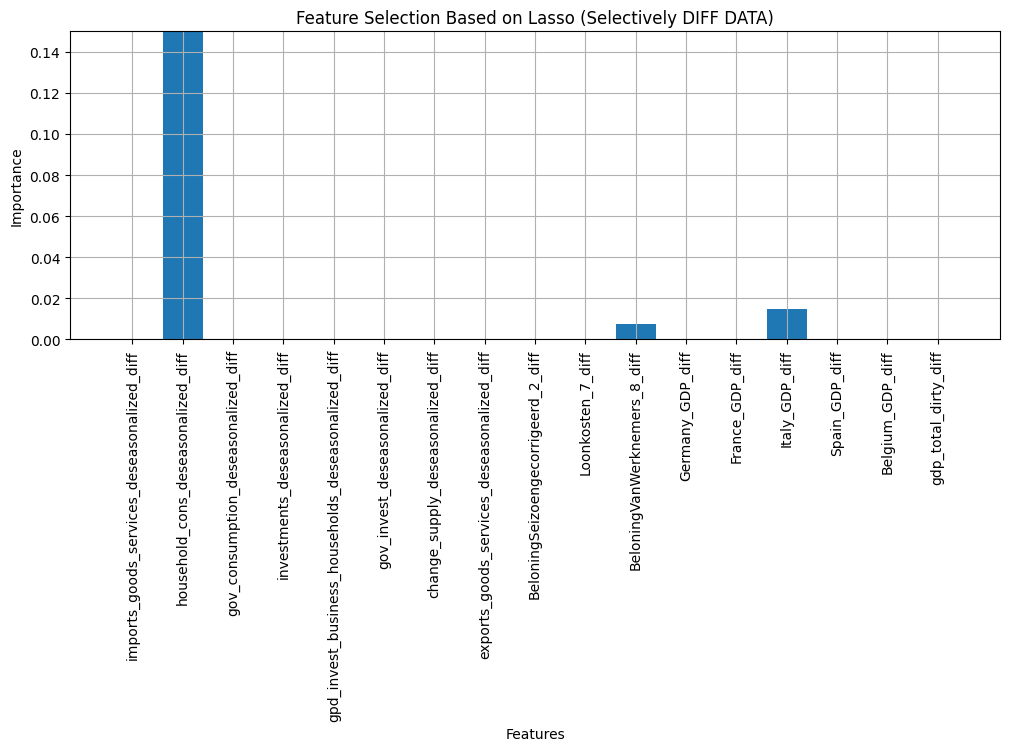

['household_cons_deseasonalized_diff',
 'BeloningVanWerknemers_8_diff',
 'Italy_GDP_diff']

In [23]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.01, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

<Axes: >

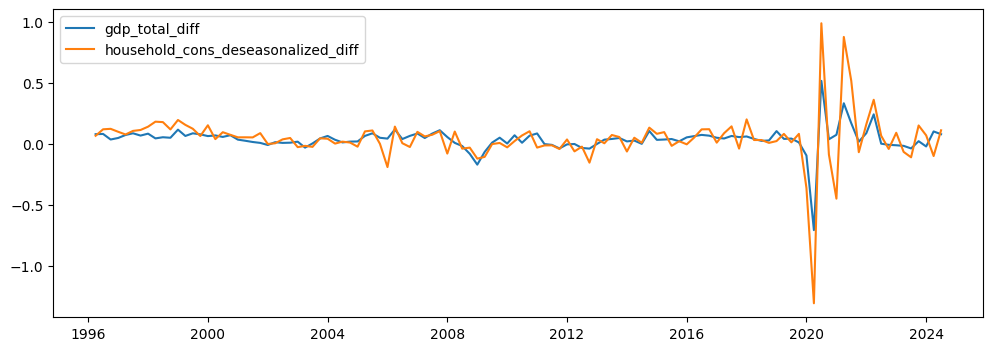

In [24]:
scaled_features_df_diff[['gdp_total_diff', 'household_cons_deseasonalized_diff']].plot()

In [25]:

df_lag_diff = differenceData(df_lag, mydiff=1)
stationdarydf(df_lag_diff, save = 'False')



,Feature,Stationary,Length
0,gdp_total_diff,Stationary,114
1,gdp_total_dirty_diff,Stationary,114
2,gdp_total_lag_1_diff,Stationary,113
3,imports_goods_services_deseasonalized_lag_1_diff,Stationary,113
4,household_cons_deseasonalized_lag_1_diff,Stationary,113
5,gov_consumption_deseasonalized_lag_1_diff,Stationary,113
6,investments_deseasonalized_lag_1_diff,Stationary,113
7,gpd_invest_business_households_deseasonalized_...,Stationary,113
8,gov_invest_deseasonalized_lag_1_diff,Stationary,113
9,change_supply_deseasonalized_lag_1_diff,Stationary,113


### Selectively diff again if needed

In [26]:

df_lag_diff_diff = differenceData(df_lag_diff, mydiff=1)
stationdarydf(df_lag_diff_diff, save = 'False')

,Feature,Stationary,Length
0,gdp_total_diff,Stationary,114
1,gdp_total_dirty_diff,Stationary,114
2,gdp_total_lag_1_diff,Stationary,113
3,imports_goods_services_deseasonalized_lag_1_diff,Stationary,113
4,household_cons_deseasonalized_lag_1_diff,Stationary,113
5,gov_consumption_deseasonalized_lag_1_diff,Stationary,113
6,investments_deseasonalized_lag_1_diff,Stationary,113
7,gpd_invest_business_households_deseasonalized_...,Stationary,113
8,gov_invest_deseasonalized_lag_1_diff,Stationary,113
9,change_supply_deseasonalized_lag_1_diff,Stationary,113


[ 0  6  8 12 13 15 16 18]
['gdp_total_dirty_diff', 'gpd_invest_business_households_deseasonalized_lag_1_diff', 'change_supply_deseasonalized_lag_1_diff', 'BeloningVanWerknemers_8_lag_1_diff', 'Germany_GDP_lag_1_diff', 'Italy_GDP_lag_1_diff', 'Spain_GDP_lag_1_diff', 'gdp_total_dirty_lag_1_diff']


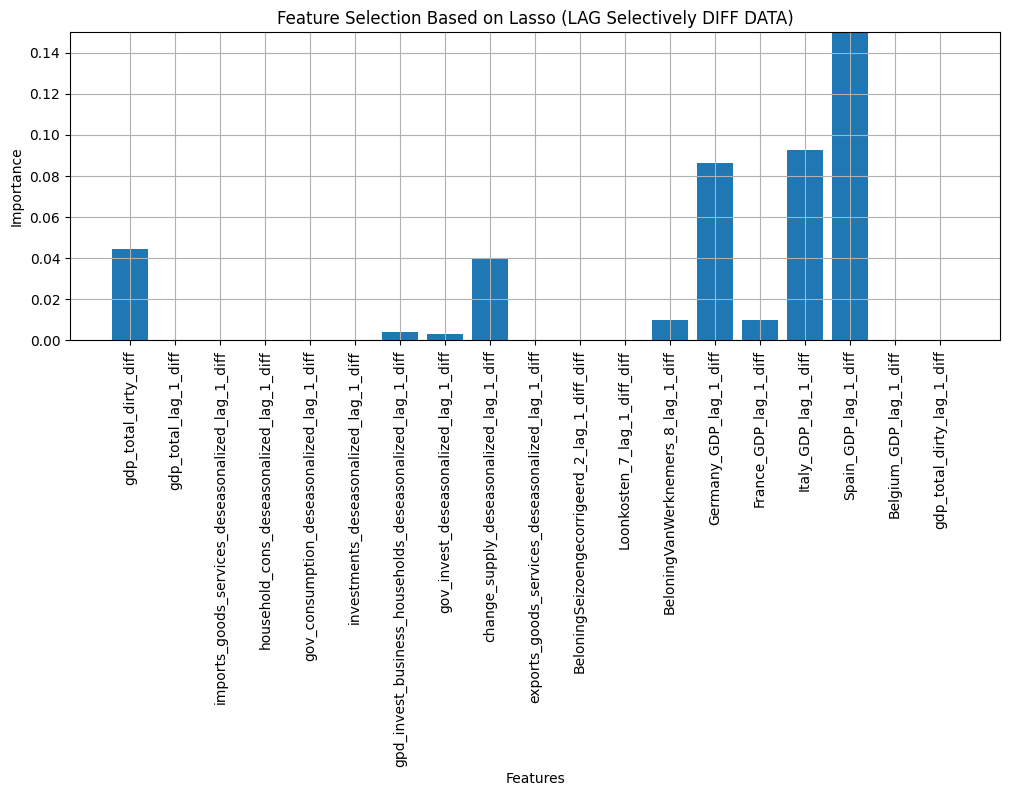

['gdp_total_dirty_diff',
 'gpd_invest_business_households_deseasonalized_lag_1_diff',
 'change_supply_deseasonalized_lag_1_diff',
 'BeloningVanWerknemers_8_lag_1_diff',
 'Germany_GDP_lag_1_diff',
 'Italy_GDP_lag_1_diff',
 'Spain_GDP_lag_1_diff',
 'gdp_total_dirty_lag_1_diff']

In [36]:
lassoreg(df_lag_diff_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG Selectively DIFF DATA)') 

In [28]:
df_lag_diff_diff

,gdp_total_diff,gdp_total_dirty_diff,gdp_total_lag_1_diff,imports_goods_services_deseasonalized_lag_1_diff,household_cons_deseasonalized_lag_1_diff,gov_consumption_deseasonalized_lag_1_diff,investments_deseasonalized_lag_1_diff,gpd_invest_business_households_deseasonalized_lag_1_diff,gov_invest_deseasonalized_lag_1_diff,change_supply_deseasonalized_lag_1_diff,exports_goods_services_deseasonalized_lag_1_diff,BeloningSeizoengecorrigeerd_2_lag_1_diff_diff,Loonkosten_7_lag_1_diff_diff,BeloningVanWerknemers_8_lag_1_diff,Germany_GDP_lag_1_diff,France_GDP_lag_1_diff,Italy_GDP_lag_1_diff,Spain_GDP_lag_1_diff,Belgium_GDP_lag_1_diff,gdp_total_dirty_lag_1_diff
1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075037,0.051576,NaN,0.302723,0.183861,NaN
1995-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.012307,-0.660243,NaN,0.129869,-0.243975,NaN,-0.175978,-0.177980,NaN
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009137,0.420688,NaN,0.126984,0.361483,NaN,0.366638,0.294269,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01,-0.040055,-0.018081,-0.018947,-0.037523,-0.068433,0.031499,-0.119022,-0.097552,-0.214723,1.791311,-0.078359,-0.012027,1.109868,-0.038959,-0.253004,0.086457,0.479123,0.328137,0.370663,0.199752
2023-10-01,0.019261,-0.004240,-0.040055,-0.179403,-0.112690,0.134794,-0.132951,-0.191625,0.338279,-1.533741,-0.120684,0.024846,-1.738398,-0.272714,0.166424,-0.191863,0.041630,-0.049543,-0.577252,-0.018081
2024-01-01,-0.023978,-0.191023,0.019261,0.091849,0.148096,0.066568,-0.153691,-0.124879,-0.277101,-0.463333,0.091815,-0.004522,1.538155,0.077918,0.198171,0.538545,0.271398,0.370943,0.847349,-0.004240
2024-04-01,0.099215,0.297516,-0.023978,-0.027763,0.067112,0.003826,0.058660,0.090099,-0.189532,-0.076614,-0.058421,-0.053827,-0.953639,-0.022727,-0.145261,-0.265230,-0.784049,-0.386379,-0.578013,-0.191023


In [29]:
df_lag_diff_diff.to_csv("tmp.csv")

In [38]:
reg1 = df_lag_diff_diff[['gdp_total_diff', 'change_supply_deseasonalized_lag_1_diff', 'Italy_GDP_lag_1_diff', 'Germany_GDP_lag_1_diff', 'Spain_GDP_lag_1_diff']]
reg1.dropna(inplace=True)

import statsmodels.api as sm

X = reg1.iloc[0:110, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:110:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:         gdp_total_diff   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     7.563
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           2.15e-05
Time:                        16:32:59   Log-Likelihood:                 108.89
No. Observations:                 110   AIC:                            -207.8
Df Residuals:                     105   BIC:                            -194.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [31]:
ypred = results.predict(X)
print(ypred)

1996-07-01    0.042358
1996-10-01    0.035260
1997-01-01    0.023307
1997-04-01    0.005036
1997-07-01    0.077249
                ...   
2022-10-01    0.050335
2023-01-01    0.004470
2023-04-01   -0.128660
2023-07-01    0.118626
2023-10-01   -0.017797
Length: 110, dtype: float64


In [32]:
Xnew = reg1.iloc[110:, 1:]
Xnew[['const']] = 1
print(Xnew)


            change_supply_deseasonalized_lag_1_diff  Italy_GDP_lag_1_diff  \
2024-01-01                                -0.463333              0.271398   
2024-04-01                                -0.076614             -0.784049   
2024-07-01                                 0.656692              0.614066   

            France_GDP_lag_1_diff  const  
2024-01-01               0.538545      1  
2024-04-01              -0.265230      1  
2024-07-01              -0.003068      1  


In [33]:

ynewpred = results.predict(Xnew)  # predict out of sample
print(ynewpred)

2024-01-01   -0.038252
2024-04-01   -0.091122
2024-07-01   -0.000094
dtype: float64


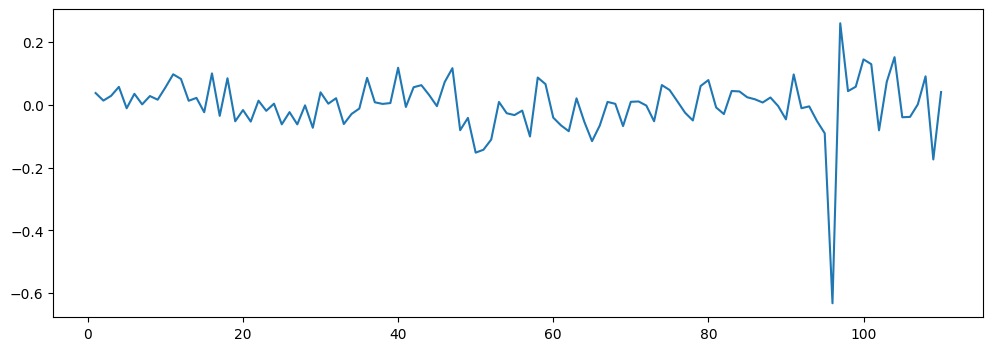

In [48]:
plt.plot(np.arange(1,(len(results.resid)+1)), results.resid)

### Homoskedasticty

In [42]:
sm.stats.diagnostic.het_breuschpagan(results.resid, X)


(11.464473158833483,
 0.021811254930695897,
 3.054151432147723,
 0.020022824710336867)

In [43]:

sm.stats.diagnostic.het_white(results.resid, X)

(77.06122737520977,
 9.88754001911144e-11,
 15.875378157869894,
 4.0512287611683254e-19)

### Collinearity

In [44]:
sm.stats.stattools.durbin_watson(results.resid, axis=0)

2.049799347093791

### Serial Correlation


### Normality

In [45]:
sm.stats.diagnostic.kstest_normal(results.resid)

(0.11893467660815259, 0.0009999999999998899)